<a href="https://colab.research.google.com/github/B-Lorentz/riverine/blob/master/py/real_sph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import jax
from jax import numpy as jnp
from jax import random as rand
from jax import grad, hessian, vmap, jit
from jax import lax
from functools import partial

(3,)
(3,)


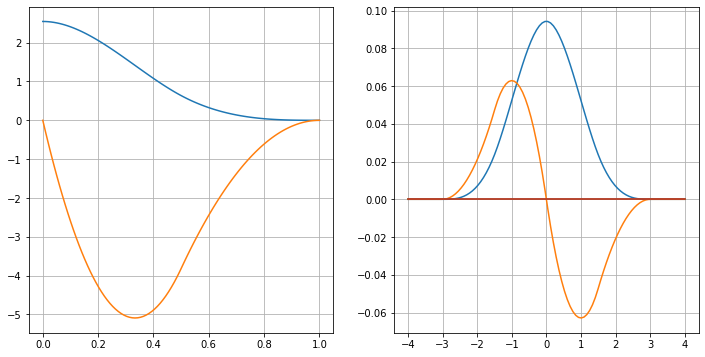

In [136]:
def W_q(q):
  
  f0 = lambda q: 6.0*(q**3 - q**2) + 1
  f1 = lambda q: 2.0*(1-q)**3
  f2 = lambda q: 0.0
  res = lax.switch(lax.mul(q, 2.0).astype(int), [f0, f1, f2], q)
  return res*8/np.pi

def W(x, h):
  print(x.shape)
  return W_q(jnp.linalg.norm(x, ord=2, axis=-1)/h)/h**3
def test_W_plot():
  
  def testplot(w, rs, lsp):
 
    ws = vmap(w, 0)(rs)
    dws = vmap(grad(w), 0)(rs)
  
    plt.plot(lsp, ws)
    plt.plot(lsp, dws)
    plt.grid()
  plt.figure(figsize=(12, 6))

  plt.subplot(121)
  lsp = np.linspace(0, 1, 100)
  testplot(W_q, lsp, lsp)

  plt.subplot(122)
  w3 = partial(W, h=3.0)
  lsp = np.linspace(-4, 4, 100)
  rs = np.zeros((100, 3))
  rs[:,0] = lsp
  testplot(w3, rs, lsp)
test_W_plot()

(3,) (2, 3) (2, 1)
(2, 3)
(3,)
(3,) (2, 3) (2, 1)
(2, 3)
(3,)


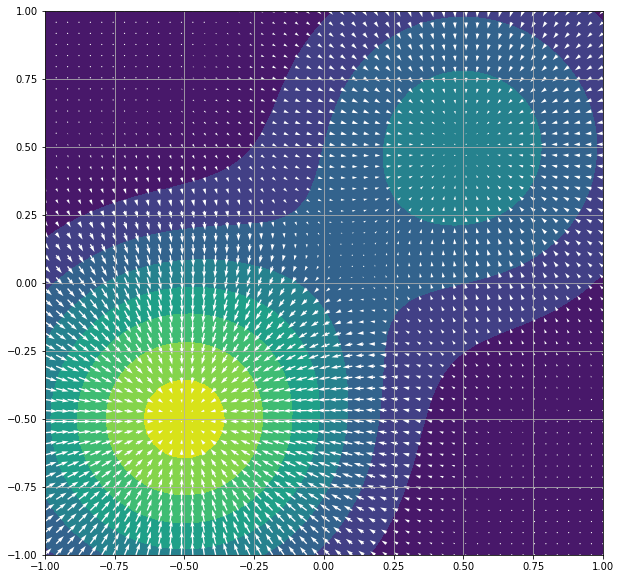

In [137]:
from jax.experimental.maps import xmap


def eval_field(x, x_parts, field, w):
  """x.shape = (3)
      x_parts.shape = (K, 3)
      field.shape = (K, D)
      return.shape = ( D)"""  
  print(x.shape, x_parts.shape, field.shape)
  dx = x - x_parts
  print(dx.shape)
  w_ij = vmap(w, 0)(dx)
  return (field*w_ij[:,np.newaxis]).sum(0)

def test_eval_field_plot():
  N = 50
  lsp = np.linspace(-1, 1, N)
  rs = np.stack(np.meshgrid(lsp, lsp, np.zeros(1)), -1)
  parts = np.array([[0.5, 0.5, 0], [-0.5, -0.5, 0]])
  field = np.array([[1.0], [2.0]])
  W_ = partial(W, h=1.4)
  concrete_field = partial(eval_field, x_parts=parts, field=field, w=W_)
  res = vmap(concrete_field, 0)(rs.reshape(-1, 3))
  gra = vmap(jax.jacfwd(concrete_field), 0)(rs.reshape(-1, 3))

  plt.figure(figsize=(10,10))
  x, y = rs[:,:,:,0].squeeze(), rs[:,:,:,1].squeeze()
  plt.contourf(x, y, res.reshape(50, 50))
  gr = gra.reshape(N, N, 3)
  plt.quiver(x, y, gr[:,:,0], gr[:,:,1], color="white")
  plt.grid()

test_eval_field_plot()

(40000, 36, 4)


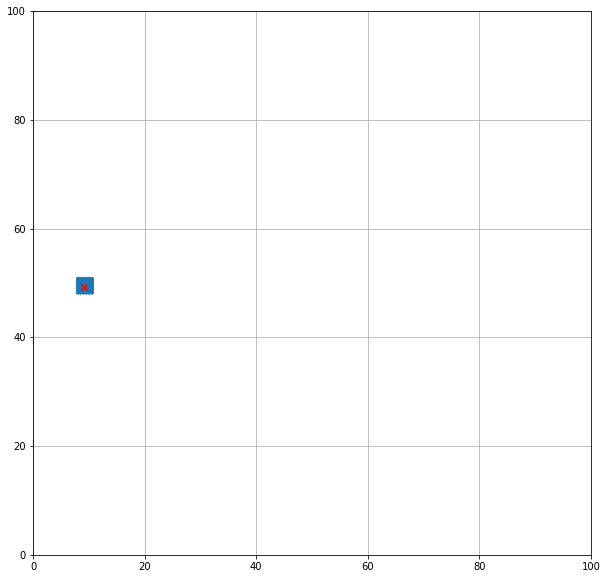

In [138]:
id = lambda x:x
dirs = np.array([[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]])
class Grid:
  def __init__(self, Xmax, Ymax, h):
    self.NX, self.NY = int(Xmax/h), int(Ymax/h)
    self.h = h
  def ktip(self, N):
    return int(N/self.NX*N/self.NY)
  def get_bins2d(self, rs):
    x = (rs[...,0]/self.h).astype(int)
    y = (rs[...,1]/self.h).astype(int)
  
    return x, y
  def get_lists(self, x, y, rs, k):
    lists = jnp.zeros((self.NX, self.NY, k, rs.shape[1]))
    inds = jnp.zeros((self.NX, self.NY), dtype=int)

    def addto(i, carry):
      lists, inds = carry
      xi, yi = jnp.take(x, i, axis=0), jnp.take(y, i, axis=0)
      ind = jnp.take(inds, xi*self.NY + yi)
      r = jnp.take(rs, i, axis=0)
      lists = lists.at[xi, yi, ind].set(r)
      inds = inds.at[xi, yi].add(1)
      return lists, inds
  
    lists, inds = lax.fori_loop(0, x.shape[0], addto, (lists, inds))
    return lists

  def get_neighbours(self, x, y, ls):
    ls = ls.reshape(self.NX*self.NY,ls.shape[-2], ls.shape[-1] )
    neighs = [jnp.take(ls, (x)*self.NY + y, axis=0)]
    for dir in dirs:
      neighs.append(jnp.take(ls, (x+dir[0])*self.NY + y+dir[1], axis=0, mode="clip"))
    return jnp.concatenate(neighs, 1)
 
def test_binning():
  N = 200
  L = 100
  gr = Grid(L, L, 1.0)
  lsp = np.linspace(0, L, N)
  rs = np.stack(np.meshgrid(lsp, lsp, np.zeros(1)), -1)
  ms = np.ones((N*N, 1))
  rf = rs.reshape(N*N, 3)
  x, y = gr.get_bins2d(rf)
 
  ls = gr.get_lists(x, y, np.concatenate((rf, ms), -1), gr.ktip(N))
  ns = gr.get_neighbours(x, y, ls)
  print(ns.shape)
  plt.figure(figsize=(10, 10))
  i = 19618
  plt.scatter(ns[i,:,0], ns[i,:,1], s=ns[i,:,3]*10)
  plt.scatter(rf[i,0], rf[i,1], marker="x", color="r")
  plt.gca().set(xlim=(0, L), ylim=(0, L))
  plt.grid()
  
test_binning()

In [142]:
def from_state(state):
  return state[...,:3], state[...,3:6], state[..., 6:7], state[..., 7:8]
def to_state(rs, vs, ms, cs):
  return jnp.concatenate((rs, vs, ms, cs), -1)

def get_ns(grid, state, rs):
  x, y = grid.get_bins2d(rs)
  ls = grid.get_lists(x, y, state, k)
  return from_state(grid.get_neighbours(x, y, ls))
def make_step(nu, g, dt, grid, k):
  h = grid.h
  W_ = partial(W, h=h)

  def step(state):
    rs, vs, ms, cs = from_state(state)

    n_rs, n_vs, n_ms, n_cs = get_ns(grid, state, rs)
    rhoer = lambda r, n_r, n_f : eval_field(r, n_r, n_f, w=W_)
    rho = vmap(rhoer, (0, 0, 0))( rs, n_rs, n_ms )
   
    return to_state(rs, vs, ms, cs)
  return step

def start_state(N, L, M):
  st = np.zeros((N, 8))
  st[:,:3] = np.random.uniform(0, L, (N, 3))
  st[:, 6] = M
  return st

def test_step():
  grid = Grid(10, 10, 1.0)
  start = start_state(1000, 10, 1.0)
  stepper = make_step(1.0, 9.81, 0.1, grid, 20)
  r = stepper(start)

test_step()

(1000, 180, 3) (1000, 3) (1000, 180, 1)
(3,) (180, 3) (180, 1)
(180, 3)
(3,)
(1000, 1)
